# Importing all the libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random
import os
from sklearn.model_selection import GridSearchCV


D:\anaconda\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
start=datetime.now()
if not os.path.isfile('data.csv'):
    data=open('data.csv',mode='w')
    row=list()
    files=['combined_data_1.txt/combined_data_1.txt','combined_data_2.txt/combined_data_2.txt','combined_data_3.txt/combined_data_3.txt','combined_data_4.txt/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            #f=f.read()
            for line in f:
                line=line.strip()
                if line.endswith(':'):
                    movie_id=line.replace(':','')
                else:
                    row=[x for x in line.split(',')]
                    row.insert(0,movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print('Done')
    data.close()
print('Time taken',datetime.now()-start)    

Time taken 0:00:00.000501


In [3]:
print('Creating the Dataframe')
df=pd.read_csv('data.csv',sep=',',names=['movie','User','Rating','date'])
df.date=pd.to_datetime(df.date)
print('Sorting the dataframe ')
df.sort_values(by='date',inplace=True)
print('Done')

Creating the Dataframe
Sorting the dataframe 
Done


In [4]:
df.head()

,movie,User,Rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [5]:
df.describe()['Rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

# Checking for NAN values

In [7]:
print('Checking the null values',sum(df.isnull().any()))

Checking the null values 0


# Removing the duplicates values

In [9]:
dup=df.duplicated(['movie','User','Rating'])
sum_dups=sum(dup)
print("There are {} duplicates elements in the ..".format(sum_dups))

There are 0 duplicates elements in the ..


# Basic Statistic #Movie,#User,#Rating

In [12]:
print('the shape of the data',df.shape)
print('total number of ratings',df.shape[0])
print('total unique rating',len(np.unique(df.User)))
print("Total No of movies  :", len(np.unique(df.movie)))

the shape of the data (100480507, 4)
total number of ratings 100480507
total unique rating 480189
Total No of movies  : 17770


# Split the Data into Train and Test

In [17]:
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv('train.csv',index=False)

    

In [22]:
if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv('test.csv',index=False)

In [4]:
train_df=pd.read_csv('train.csv',parse_dates=['date'])

In [5]:
test_df=pd.read_csv('test.csv')

# Basic statictics on Training data

In [14]:
print('the shape of the data',train_df.shape)
print('total number of ratings',train_df.shape[0])
print('total unique rating',len(np.unique(train_df.User)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

the shape of the data (80384405, 4)
total number of ratings 80384405
total unique rating 405041
Total No of movies  : 17424


In [15]:
print('the shape of the data',test_df.shape)
print('total number of ratings',test_df.shape[0])
print('total unique rating',len(np.unique(test_df.User)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

the shape of the data (20096102, 4)
total number of ratings 20096102
total unique rating 349312
Total No of movies  : 17757


In [7]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

# Distribution of ratings

In [8]:
fx,ax=plt.subplots()
plt.title('Ditribution of the rating')
sns.countplot(train_df['Rating'])
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

Text(0,0.5,'No. of Ratings(Millions)')

# Add new column(week day) to the data set analysis

In [9]:
pd.options.mode.chained_assignment=None

In [19]:
train_df['day_of_week']=train_df.date.dt.weekday_name

In [20]:
train_df.head()

,movie,User,Rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


In [21]:
train_df.tail()

,movie,User,Rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


# Number of ratings per a month

<IPython.core.display.Javascript object>


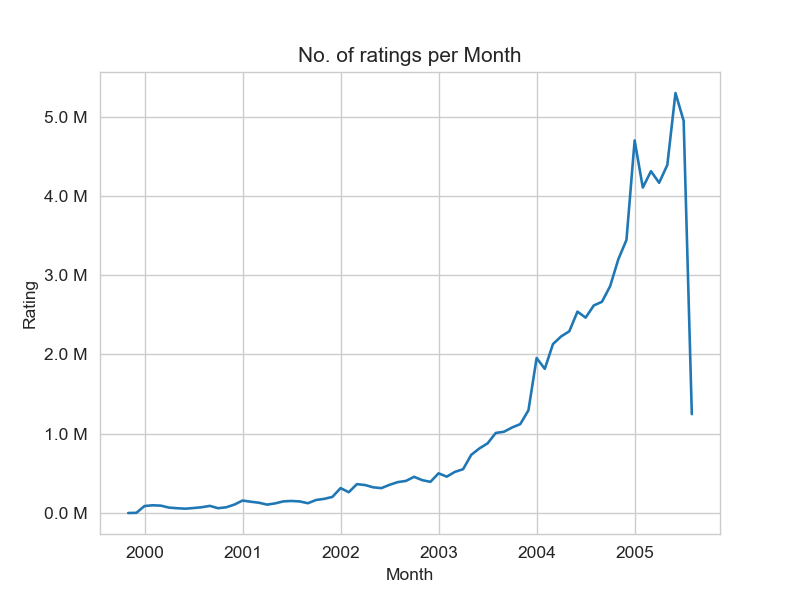

In [23]:
ax=train_df.resample('m',on='date')['Rating'].count().plot()
ax.set_title('No. of ratings per Month')
plt.xlabel('Month')
plt.ylabel('Rating')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

# Analysis on the rating given by the user

In [10]:
no_rate_movies_per_user=train_df.groupby(by='User')['Rating'].count().sort_values(ascending=False)

In [11]:
no_rate_movies_per_user.head()

User
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: Rating, dtype: int64

In [26]:
fig=plt.figure(figsize=plt.figaspect(0.3))
ax1=plt.subplot(121)
sns.kdeplot(no_rate_movies_per_user,shade=True,ax=ax1)
plt.xlabel('No. of ratings by user')
plt.ylabel('PDF')

ax2=plt.subplot(122)
sns.kdeplot(no_rate_movies_per_user,shade=True,cumulative=True,ax=ax2)
plt.xlabel('No. of ratings given by user')
plt.ylabel('CDF')

Text(0,0.5,'CDF')

In [12]:
no_rate_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: Rating, dtype: float64

In [28]:
quantiles=no_rate_movies_per_user.quantile(np.arange(0,1.01,0.01),interpolation='higher')

<IPython.core.display.Javascript object>


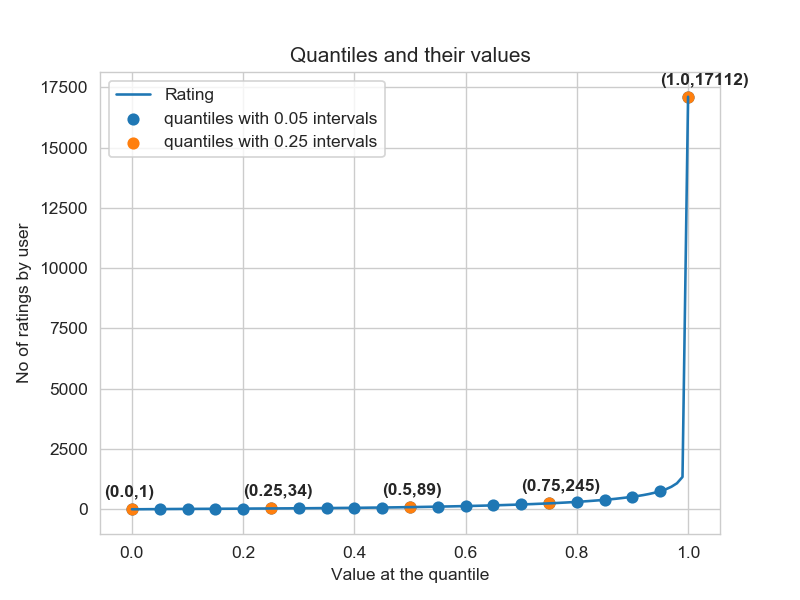

In [30]:
plt.title('Quantiles and their values')
quantiles.plot()
plt.scatter(x=quantiles.index[::5],y=quantiles.values[::5],cmap='orange',label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25],y=quantiles.values[::25],cmap='m',label="quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25],quantiles.values[::25]):
    plt.annotate(s="({},{})".format(x,y),xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')
plt.show()    

In [44]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: Rating, dtype: int64

In [45]:
print('\n no. of ratings at last 5 percentile: {}\n'.format(sum(no_rate_movies_per_user>=749)))


 no. of ratings at last 5 percentile: 20305



# Analysis of ratings of a movie given by the user

In [13]:
no_of_ratings_per_movie=train_df.groupby(by='movie')['Rating'].count().sort_values(ascending=False)

<IPython.core.display.Javascript object>


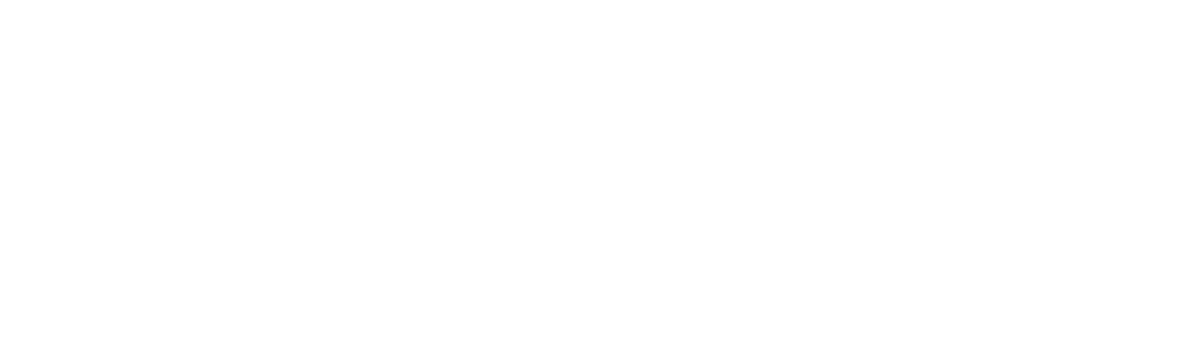

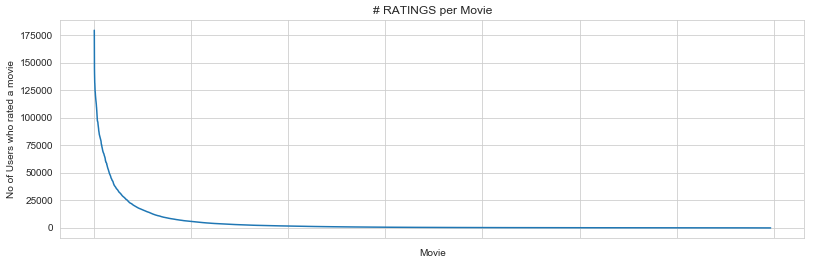

In [52]:
fig = plt.figure(figsize=plt.figaspect(.3))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])
plt.show()

# No. of ratings based on the weekdays

<IPython.core.display.Javascript object>


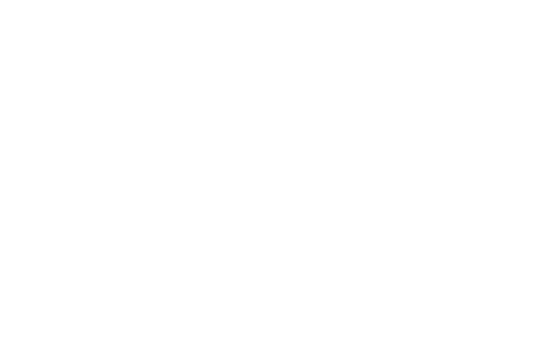

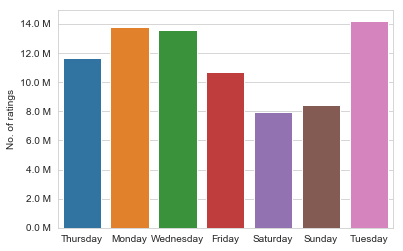

In [57]:
fig,ax=plt.subplots()
sns.countplot(x='day_of_week',data=train_df,ax=ax)
plt.xlabel('Days of week')
plt.ylabel('No. of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


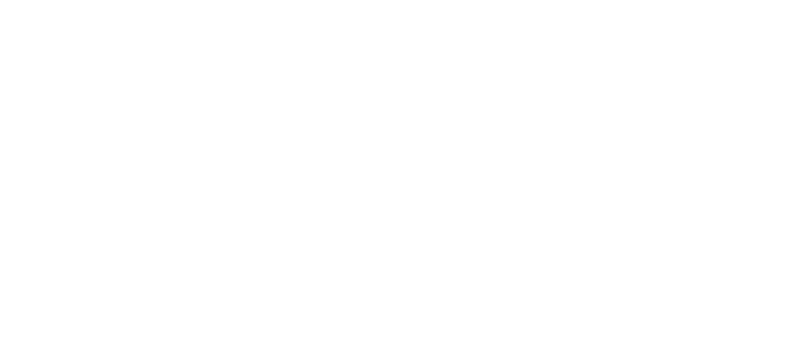

0:00:36.964347


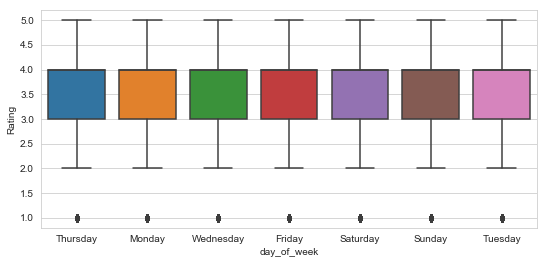

In [59]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='Rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

In [61]:
avg_week_df = train_df.groupby(by=['day_of_week'])['Rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: Rating, dtype: float64




Observation: What we find that every day the average rating is 3.5 so this is not telling much as a feature

# Creating a sparse Matrix from the dataframe

In [6]:
start=datetime.now()
print('Creating a sparse dataframe')
if os.path.isfile('train_sparse_matrix.npz'):
    print('It is present in your system just laod it .....')
    train_sparse_matrix=sparse.load_npz('train_sparse_matrix.npz')
    print('Done')
else:
    if not os.path.isfile('train_sparse_matrix.npz'):
        print('Creating a sparse matrix from the dataframe')
        train_sparse_matrix=sparse.csr_matrix((train_df.Rating.values,(train_df.User.values,train_df.movie.values)),)
        print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
        print('Saving it into disk for furthur usage..')
        # save it into disk
        sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
        print('Done..\n')

print(datetime.now() - start)

Creating a sparse dataframe
It is present in your system just laod it .....
Done
0:00:03.948676


In [7]:
us,mv=train_sparse_matrix.shape
ele=train_sparse_matrix.count_nonzero()
print("Sparsity Of Train matrix : {} % ".format(  (1-(ele/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.95731772988694 % 


In [8]:
start=datetime.now()
print('Creating a sparse dataframe')
if os.path.isfile('test_sparse_matrix.npz'):
    print('It is present in your system just laod it .....')
    test_sparse_matrix=sparse.load_npz('test_sparse_matrix.npz')
    print('Done')
else:
    if not os.path.isfile('test_sparse_matrix.npz'):
        print('Creating a sparse matrix from the dataframe')
        test_sparse_matrix=sparse.csr_matrix((test_df.Rating.values,(test_df.User.values,test_df.movie.values)),)
        print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
        print('Saving it into disk for furthur usage..')
        # save it into disk
        sparse.save_npz("train_sparse_matrix.npz", test_sparse_matrix)
        print('Done..\n')

print(datetime.now() - start)

Creating a sparse dataframe
Creating a sparse matrix from the dataframe
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:00:21.260162


In [9]:
us,mv=test_sparse_matrix.shape
ele=test_sparse_matrix.count_nonzero()
print("Sparsity Of Train matrix : {} % ".format(  (1-(ele/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.95731772988694 % 


# Find Global Average of all Movie ratings,Average rating per User,and Average Raing per Movie

# Find Global Average rating of all the user

In [18]:
train_averages= dict()
train_global_average=train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()

In [19]:
train_averages['Global']=train_global_average
train_averages

{'Global': 3.6898870736225362}

In [20]:
def average_ratings(sparse_matrix,of_users):
    ax=1 if of_users else 0
    sum_of_ratings=sparse_matrix.sum(axis=ax).A1
    is_rated=sparse_matrix!=0
    no_of_ratings=is_rated.sum(axis=ax).A1
    u,m=sparse_matrix.shape
    average_rating={i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}
    
    return average_rating    

# Find the average rating per user

In [21]:
train_averages['user']=average_ratings(train_sparse_matrix,of_users=True)
print('The average user rating',train_averages['user'][10])

The average user rating 3.4406779661


In [15]:
train_averages['movie']=average_ratings(train_sparse_matrix,of_users=False)
print('The average movie rating',train_averages['movie'][15])

The average movie rating 3.13333333333


# Pdf and CDF of User as well as Movie Rating

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


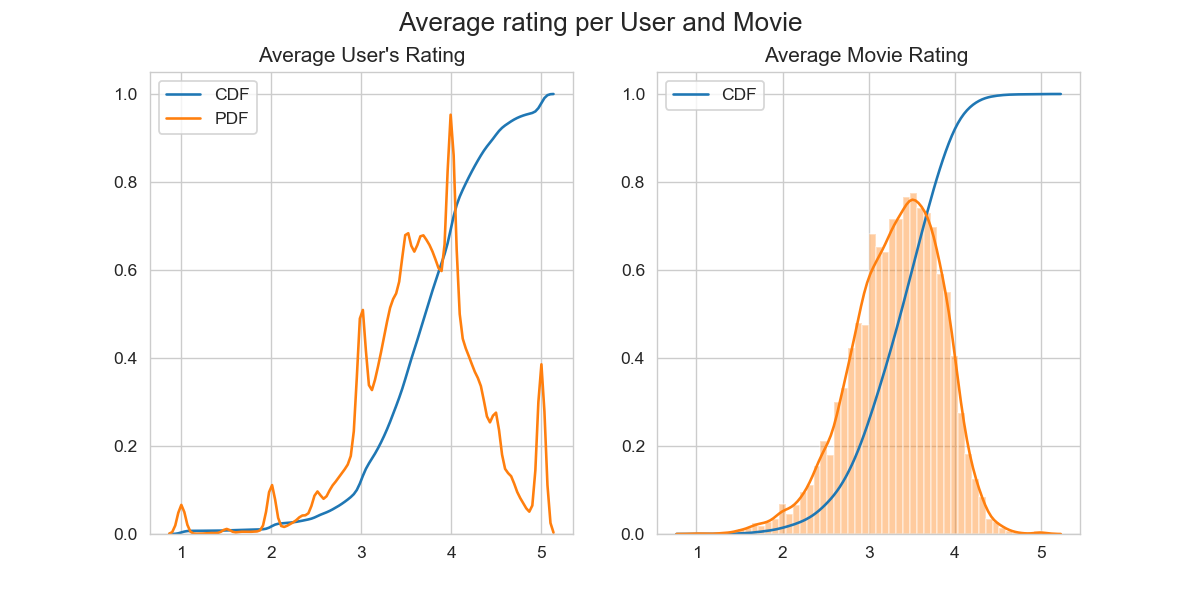

In [21]:
#start=datetime.now()
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=plt.figaspect(0.5))
fig.suptitle('Average rating per User and Movie',fontsize=15)
ax1.set_title("Average User's Rating")
user_average_rat=[rat for rat in train_averages['user'].values()]
sns.distplot(user_average_rat,ax=ax1,label='CDF',kde_kws=dict(cumulative=True),hist=False)
sns.distplot(user_average_rat,ax=ax1,label='PDF',hist=False)
ax2.set_title('Average Movie Rating ')
movies_average_rat=[rat for rat in train_averages['movie'].values()]
sns.distplot(movies_average_rat,ax=ax2,label='CDF',hist=False,kde_kws=dict(cumulative=True))
sns.distplot(movies_average_rat,ax=ax2,label='PDF')
plt.show()


# Cold Start Problem with USER

In [17]:
total_users=len(np.unique(df.User))
train_users=len(np.unique(train_df.User))
new_users = total_users - train_users

In [18]:
print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', train_users)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


# 75148 Users who didn't appear on our training data

# Cold Start Problem with Movies

In [25]:
total_movies=len(np.unique(df.movie))
movie_train=len(np.unique(train_df.movie))
new_movies=total_movies - movie_train

In [26]:
print('Total number of new Movie:',total_movies)
print('\n Number of Movies in train Data: ',movie_train)
print('\n Number of movies that did not appear in the training data :{}({}%) \n'.format(new_movies,np.round(new_movies/total_movies)*100,2))

Total number of new Movie: 17770

 Number of Movies in train Data:  17424

 Number of movies that did not appear in the training data :346(0.0%) 



# Computing Movie-Movie similarity Matrix

In [27]:
start=datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print('It seems you don not have the file')
    start=datetime.now()
    m_m_sim_sparse=cosine_similarity(X=train_sparse_matrix.T,dense_output=False)
    print('Done')
    sparse.save_npz('m_m_sim_sparse.npz',m_m_sim_sparse)
    print('Done........')
else:
    print('It is there We will get......')
    m_m_sim_sparse=sparse.load_npz('m_m_sim_sparse.npz')
    print('Done')
print('The shape',m_m_sim_sparse.shape,'Dimensional Matrix')
print(datetime.now()-start)    

It is there We will get......
Done
The shape (17771, 17771) Dimensional Matrix
0:00:25.271364


In [28]:
m_m_sim_sparse.shape

(17771, 17771)

In [34]:
#movie_ids=np.unique(m_m_sim_sparse.nonzero()[1])

In [ ]:
start=datetime.now()
similar_movie=dict()
for movie in movie_ids:
    sim_movie=train_sparse_matrix[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movie[movie]=sim_movie[:100]
print(datetime.now()-start)            

In [21]:
similar_movie[15]

array([5925, 5919, 5920, 5921, 5922, 5923, 5924, 5926, 5934, 5927, 5928,
       5929, 5930, 5931, 5932, 5918, 5917, 5916, 5915, 5914, 5913, 5912,
       5911, 5910, 5909, 5908, 5907, 5906, 5905, 5904, 5903, 5902, 5933,
       5935, 5969, 5960, 5954, 5955, 5956, 5957, 5958, 5959, 5961, 5936,
       5962, 5963, 5964, 5965, 5966, 5967, 5953, 5952, 5951, 5950, 5949,
       5948, 5947, 5946, 5945, 5944, 5943, 5942, 5941, 5940, 5939, 5938,
       5937, 5901, 5900, 5899, 5856, 5850, 5851, 5852, 5853, 5854, 5855,
       5857, 5898, 5858, 5859, 5860, 5861, 5862, 5863, 5849, 5848, 5847,
       5846, 5845, 5844, 5843, 5842, 5841, 5840, 5839, 5838, 5837, 5836,
       5835], dtype=int64)

# Finding more similar movie using similarity matrix

In [16]:

movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 4.01 ms
Type conversion took: 11.53 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [17]:
print('\nMovie-----',movie_titles.iloc[68].values[1])


Movie----- WWE: Armageddon 2003


In [18]:
print('\n It has {} Ratings from User'.format(train_sparse_matrix[:68].getnnz()))


 It has 413 Ratings from User


In [20]:
#print('\n we have {} movies similar to this '.format(m_m_sim_sparse[:,68].getnnz()))

In [42]:
mv_id=68
similarities=m_m_sim_sparse[:,mv_id].toarray().ravel()

In [43]:
similar_indices=similarities.argsort()[::-1][1:]

In [44]:
similarities[similar_indices]

array([0.13357034, 0.13149421, 0.08740826, ..., 0.        , 0.        ,
       0.        ])

In [45]:
sim_indices = similarities.argsort()[::-1][1:]

<IPython.core.display.Javascript object>


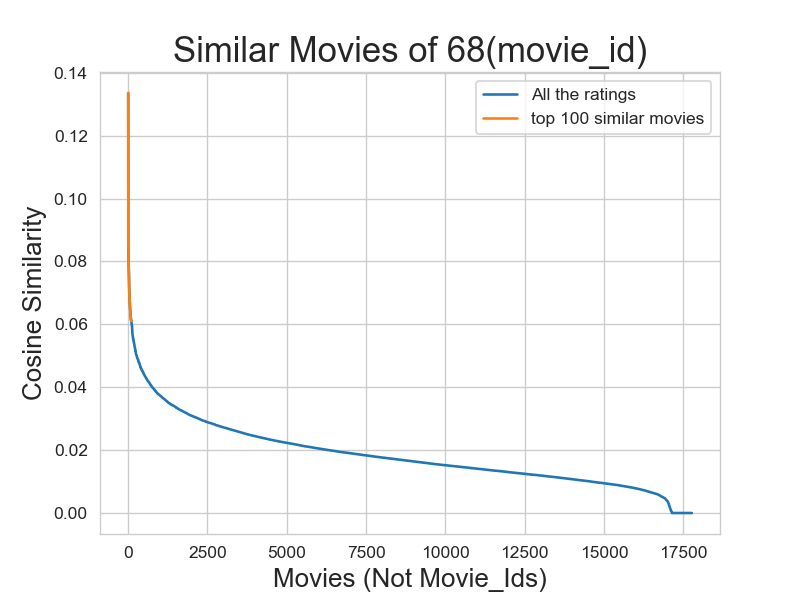

In [47]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [48]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
14661,2001.0,Samurai Jack: Season 1
9296,2001.0,Samurai Jack
7695,1999.0,Futurama: Vol. 2
9475,1994.0,The Critic: The Complete Series
15557,1999.0,Futurama: Vol. 3
316,1999.0,Futurama: Monster Robot Maniac Fun Collection
2756,1992.0,Tenchi Muyo
7104,2002.0,Home Movies: Season 2
5945,1999.0,Home Movies: Season 1


# Machine Learning Model

# Sampling the train Data with 25K user and 3k movies

In [10]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

In [11]:
start=datetime.now()
path="sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print('It is present in your system')
    sample_train_sparse_matrix=sparse.load_npz(path)
else:
    sample_train_sparse_matrix=get_sample_sparse_matrix(train_sparse_matrix,no_users=25000,no_movies=3000,path=path)
print(datetime.now()-start)       

It is present in your system
0:00:00.059157


# Building a sample Test data

In [12]:
start=datetime.now()
path="sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print('It is present in your system')
    sample_test_sparse_matrix=sparse.load_npz(path)
else:
    sample_test_sparse_matrix=get_sample_sparse_matrix(test_sparse_matrix,no_users=10000,no_movies=1000,path=path)
print(datetime.now()-start)         

It is present in your system
0:00:00.040137


# Finding global rating average of the Sampled Data

In [13]:
sample_train_average=dict()

In [14]:
global_average=sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_average['global']=global_average
sample_train_average

{'global': 3.6738888697825316}

# Finding average rating per user

In [22]:
sample_train_average['user'] = average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 14628 :',sample_train_average['user'][14628])


Average rating of user 14628 : 3.66666666667


# Finding average rating per movie

In [23]:
sample_train_average['movie'] = average_ratings(sample_train_sparse_matrix, of_users=False)
print('\nAverage rating of user 5472 :',sample_train_average['movie'][5472])


Average rating of user 5472 : 3.67730802416


# Featurizing the data 

In [24]:
sample_train_users, sample_train_movies,sample_train_ratings =sparse.find(sample_train_sparse_matrix)

In [25]:
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()

            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_average['movie'][movie]]*(5 - len(top_sim_users_ratings)))       
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:]

            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
    
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_average['user'][user]]*(5-len(top_sim_movies_ratings))) 

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_average['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_average['user'][user])
            # Avg_movie rating
            row.append(sample_train_average['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001505


In [26]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1129620,2,3.673889,3.0,3.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,4.000000,3.00,3
1,3321,5,3.673889,4.0,1.0,3.0,4.0,4.0,4.0,3.0,4.0,2.0,1.0,2.285714,3.48,4
2,368977,5,3.673889,4.0,4.0,5.0,4.0,1.0,5.0,5.0,5.0,5.0,5.0,5.000000,3.48,5
3,508584,5,3.673889,5.0,3.0,1.0,4.0,3.0,3.0,2.0,4.0,3.0,3.0,2.981273,3.48,3
4,731988,5,3.673889,4.0,4.0,1.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,3.460000,3.48,2


In [27]:
sample_test_users, sample_test_movies,sample_test_ratings =sparse.find(sample_test_sparse_matrix)

In [28]:
start = datetime.now()
if os.path.isfile('reg_test.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()        
            user_sim = cosine_similarity(sample_test_sparse_matrix[user], sample_test_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] 
            top_ratings = sample_test_sparse_matrix[top_sim_users, movie].toarray().ravel()

            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_average['movie'][movie]]*(5 - len(top_sim_users_ratings)))       
            movie_sim = cosine_similarity(sample_test_sparse_matrix[:,movie].T, sample_test_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:]

            top_ratings = sample_test_sparse_matrix[user, top_sim_movies].toarray().ravel()
    
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_average['user'][user]]*(5-len(top_sim_movies_ratings))) 

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_average['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_average['user'][user])
            # Avg_movie rating
            row.append(sample_train_average['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001471


In [29]:
reg_test_df=pd.read_csv('reg_test.csv',names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)

In [30]:
reg_test_df.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.50,3.500000,3.500000,3.500000,3.500000,3.500000,3.526316,5
1,941866,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.80,3.800000,3.800000,3.800000,3.800000,3.800000,3.526316,4
2,1737912,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,4.25,4.250000,4.250000,4.250000,4.250000,4.250000,3.526316,3
3,1849204,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,4.50,4.500000,4.500000,4.500000,4.500000,4.500000,3.526316,4
4,28572,111,3.673889,2.0,4.0,4.0,1.000000,3.000000,4.00,3.941176,3.941176,3.941176,3.941176,3.941176,3.200873,1


# Transforming data for Surprise Model

In [31]:
from surprise import Reader, Dataset

In [32]:
reader=Reader(rating_scale=(1,5))
train_data=Dataset.load_from_df(reg_train[['user','movie','rating']],reader)
trainset=train_data.build_full_trainset()

# transforming test data

In [33]:
testset=list(zip(reg_test_df.user.values,reg_test_df.movie.values,reg_test_df.rating.values))

In [34]:
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

# Applying Machine Learning Model

In [35]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [36]:
def get_error_metric(y_true,y_pred):
    rmse=np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape=np.mean(np.abs(y_true-y_pred)/y_true)*100
    return rmse,mape 

In [37]:
def run_xgboost(algo,x_train,y_train,x_test,y_test,verbose=True):
    train_result=dict()
    test_result=dict()
    start=datetime.now()
    print('Training the model')
    algo.fit(x_train,y_train,eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')
    print('Evaluating the model with the training data')
    start=datetime.now()
    y_train_predic=algo.predict(x_train)
    rmse_train,mape_train=get_error_metric(y_train.values,y_train_predic)
    train_result = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_predic}
    
    print('Evaluating the Test Data')
    start=datetime.now()
    y_test_predic=algo.predict(x_test)
    rmse_test,mape_test=get_error_metric(y_test.values,y_test_predic)
    test_result={'rmse':rmse_test,
                 'mape':mape_test,
                 'prediction':y_test_predic}
    
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_result, test_result

# Xgboost with intial 13 features

In [38]:
import xgboost as xgb

Training the model
Done. Time taken : 0:00:03.962457

Done 

Evaluating the model with the training data
Evaluating the Test Data

TEST DATA
------------------------------
RMSE :  0.865230667502
MAPE :  25.8808454378


<IPython.core.display.Javascript object>


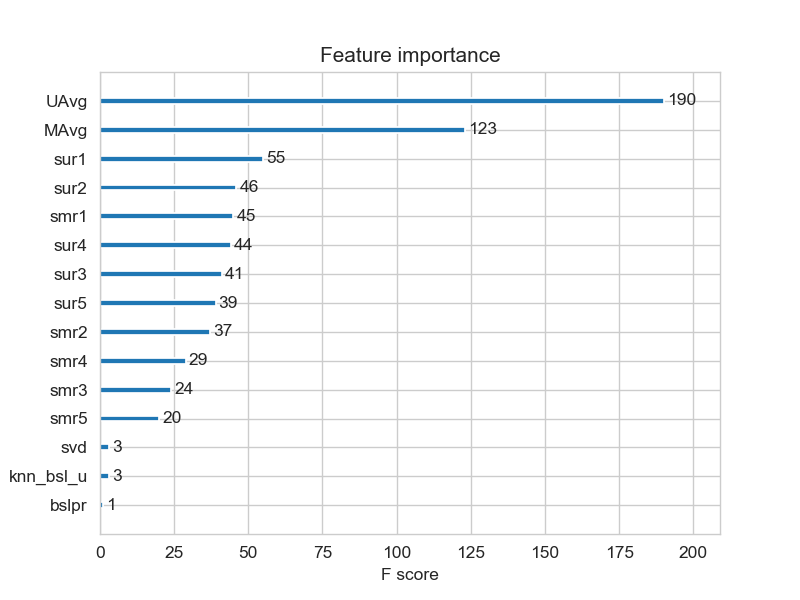

In [81]:
x_train=reg_train.drop(['user','movie','rating'],axis=1)
y_train=reg_train['rating']

x_test=reg_test_df.drop(['user','movie','rating'],axis=1)
y_test=reg_test_df['rating']

first_xgb=xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_result,test_result=run_xgboost(first_xgb,x_train,y_train,x_test,y_test)
models_evaluation_train['first_algo'] = train_result
models_evaluation_test['first_algo'] = test_result

xgb.plot_importance(first_xgb)
plt.show()

# Surprise using BaseLine Model

In [41]:
from surprise import BaselineOnly

In [42]:
my_seed=15
random.seed(my_seed)
np.random.seed(my_seed)
def get_ratings(predictions):
    actual=np.array([pred.r_ui for pred in predictions])
    pred=np.array([pred.est for pred in predictions])
    return actual,pred

In [43]:
def get_errors(predictions,print_them=False):
    true,pred=get_ratings(predictions)
    rmse=np.sqrt(np.mean((pred - true)**2))
    mape=np.mean(np.abs(pred - true)/true)
    return rmse , mape*100    

In [44]:
def run_surprise(algo, trainset, testset, verbose=True): 
    
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
   
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

In [45]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:02.026197 

Evaluating the model with train data..
time taken : 0:00:02.490763
---------------
Train Data
---------------
RMSE : 0.9528229223632284

MAPE : 29.497559419327168

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.048673
---------------
Test Data
---------------
RMSE : 0.9500050808941297

MAPE : 29.962432015093665

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:04.566548


# XGBoost with intial 13 features + surprise baseline Model

In [46]:
reg_train['bslpr']=models_evaluation_train['bsl_algo']['predictions']
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1129620,2,3.673889,3.0,3.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,4.000000,3.00,3,3.693325
1,3321,5,3.673889,4.0,1.0,3.0,4.0,4.0,4.0,3.0,4.0,2.0,1.0,2.285714,3.48,4,3.892235
2,368977,5,3.673889,4.0,4.0,5.0,4.0,1.0,5.0,5.0,5.0,5.0,5.0,5.000000,3.48,5,4.099031
3,508584,5,3.673889,5.0,3.0,1.0,4.0,3.0,3.0,2.0,4.0,3.0,3.0,2.981273,3.48,3,3.764010
4,731988,5,3.673889,4.0,4.0,1.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,3.460000,3.48,2,3.723804


In [47]:
reg_test_df['bslpr']=models_evaluation_test['bsl_algo']['predictions']
reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.5,3.5,3.5,3.5,3.5,3.5,3.526316,5,3.605223
1,941866,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.8,3.8,3.8,3.8,3.8,3.8,3.526316,4,3.654285


Training the model
Done. Time taken : 0:00:04.972215

Done 

Evaluating the model with the training data
Evaluating the Test Data

TEST DATA
------------------------------
RMSE :  0.865175265726
MAPE :  25.8704920275


<IPython.core.display.Javascript object>


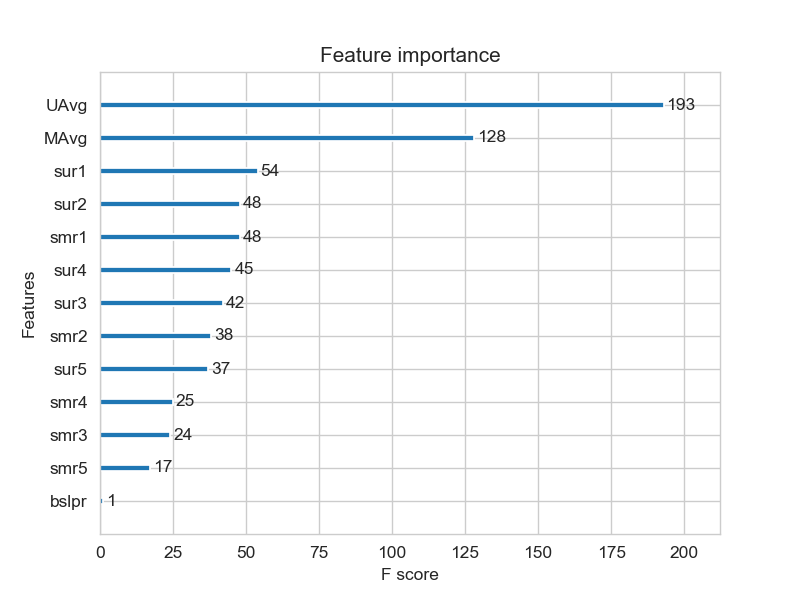

In [48]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


# hyperparameter Tunning

In [66]:
param={"learning_rate" : [0.15, 0.20, 0.25,0.5,0.7] ,
 "max_depth": [ 3, 4, 5, 6, 8, 10, 12],
 "n_estimators" : [ 100, 200, 400, 600,800,1000],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],}

In [62]:
grid=GridSearchCV(x1,param_grid=param)
grid_result=grid.fit(x_train,y_train)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [63]:
grid_result.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
x1=xgb.XGBRegressor(learning_rate=0.5,max_depth=5,n_estimators=100,gamma=0)

Training the model
Done. Time taken : 0:00:18.839243

Done 

Evaluating the model with the training data
Evaluating the Test Data

TEST DATA
------------------------------
RMSE :  0.936650861175
MAPE :  27.504494587


<IPython.core.display.Javascript object>


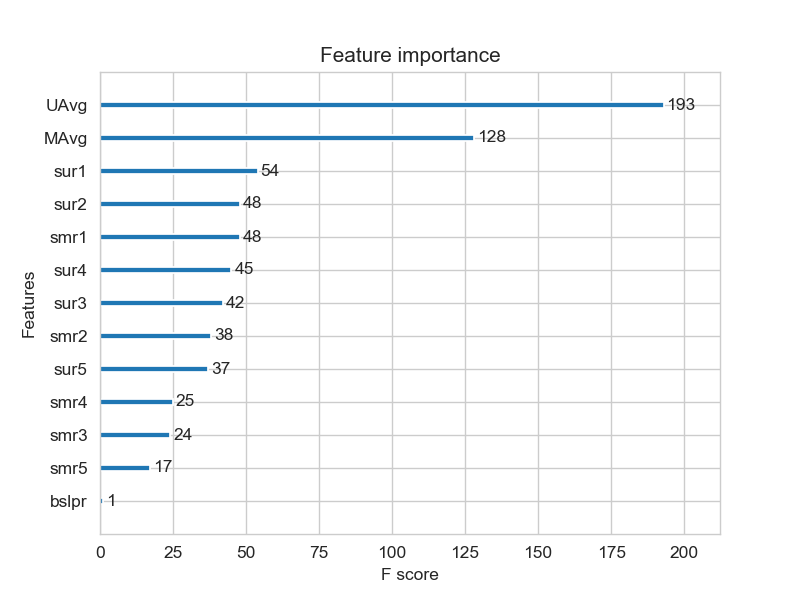

In [50]:
train_results, test_results = run_xgboost(x1, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

# Surprise KNNBaseLine Predictors

In [51]:
from surprise import KNNBaseline

# Surprise KNNBaseLine with user user similarity

In [52]:


bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:48.929775 

Evaluating the model with train data..
time taken : 0:02:53.990577
---------------
Train Data
---------------
RMSE : 0.42494854386124187

MAPE : 10.804250649877405

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:03.704358
---------------
Test Data
---------------
RMSE : 0.4238832954812264

MAPE : 11.057580020436738

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:03:46.661309


In [53]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:06.696341 

Evaluating the model with train data..
time taken : 0:00:21.636209
---------------
Train Data
---------------
RMSE : 0.3293302717910726

MAPE : 7.992142090942942

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.631365
---------------
Test Data
---------------
RMSE : 0.32123876330769335

MAPE : 8.076456933385211

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:28.964922


# XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor 


In [54]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1129620,2,3.673889,3.0,3.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,4.000000,3.00,3,3.693325,3.000000,3.000000
1,3321,5,3.673889,4.0,1.0,3.0,4.0,4.0,4.0,3.0,4.0,2.0,1.0,2.285714,3.48,4,3.892235,4.163353,4.025879


In [55]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.5,3.5,3.5,3.5,3.5,3.5,3.526316,5,3.605223,4.162350,4.992423
1,941866,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.8,3.8,3.8,3.8,3.8,3.8,3.526316,4,3.654285,3.996594,4.009513


# Hyperparameter Tunning of the Xgboost 

In [62]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [66]:
param={"learning_rate" : [0.15, 0.20, 0.25,0.5,0.7] ,
 "n_estimators" : [ 100, 200, 400, 600,800,1000],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}

In [68]:
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15,max_depth=3)
grid=GridSearchCV(xgb_knn_bsl,param_grid=param)
grid_res=grid.fit(x_train,y_train)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [69]:
grid_res.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [84]:
x2=xgb.XGBRegressor(max_depth=3,learning_rate=0.2,n_estimators=1000,gamma=0.0)

Training the model
Done. Time taken : 0:01:59.710538

Done 

Evaluating the model with the training data
Evaluating the Test Data

TEST DATA
------------------------------
RMSE :  0.867476183026
MAPE :  25.9164493309


<IPython.core.display.Javascript object>


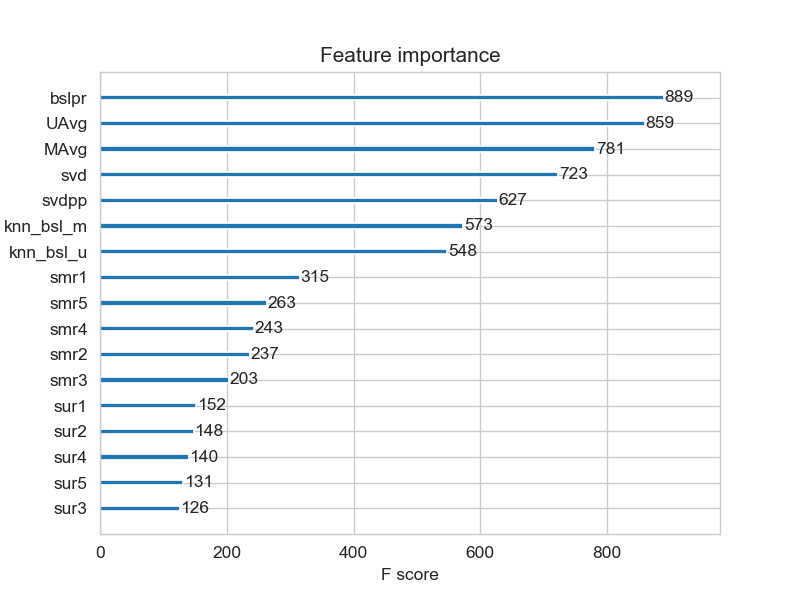

In [85]:
# declare the model

train_results, test_results = run_xgboost(x2, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(x2)
plt.show()

# Matrix factorization technique

In [56]:
from surprise import SVD

In [57]:
svd=SVD(n_factors=100,biased=True,random_state=15,verbose=True)
svd_train_results, svd_test_results =run_surprise(svd,trainset,testset,verbose=True)
models_evaluation_train['svd']=svd_train_results
models_evaluation_test['svd']=svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:17.933444 

Evaluating the model with train data..
time taken : 0:00:04.355392
---------------
Train Data
---------------
RMSE : 0.653251918197179

MAPE : 19.26626925809691

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.090280
---------------
Test Data
---------------
RMSE : 0.6381376845203351

MAPE : 19.29202561959908

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:22.380115


# SVD Matrix factorization with implicit Feedback from User

In [58]:
from surprise import SVDpp

In [59]:
svdpp=SVDpp(n_factors=50,random_state=15,verbose=True)
svdpp_train_results,svdpp_test_results=run_surprise(svdpp,trainset,testset,verbose=True)
models_evaluation_train['svdpp']=svdpp_train_results
models_evaluation_test['svdpp']=svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:05:59.028646 

Evaluating the model with train data..
time taken : 0:00:16.480445
---------------
Train Data
---------------
RMSE : 0.608674760954341

MAPE : 17.40637981676393

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.719197
---------------
Test Data
---------------
RMSE : 0.6019028332349853

MAPE : 17.638619506387936

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:06:16.229252


# XGboost + Surprise Baslineonly + Surprise KNNBaseline + SVD + SVD++

In [60]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1129620,2,3.673889,3.0,3.0,3.0,3.0,3.0,4.0,4.0,...,4.0,4.0,4.000000,3.00,3,3.693325,3.000000,3.000000,3.538068,3.618862
1,3321,5,3.673889,4.0,1.0,3.0,4.0,4.0,4.0,3.0,...,2.0,1.0,2.285714,3.48,4,3.892235,4.163353,4.025879,3.948975,4.075661


In [61]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.5,3.5,...,3.5,3.5,3.5,3.526316,5,3.605223,4.162350,4.992423,3.662556,3.950866
1,941866,71,3.673889,5.0,4.0,3.0,3.526316,3.526316,3.8,3.8,...,3.8,3.8,3.8,3.526316,4,3.654285,3.996594,4.009513,3.757972,3.859291


In [62]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



# Hyperparamater Tunning of XGboost with all the features 

In [63]:
param={"learning_rate" : [0.15, 0.20, 0.25,0.5,0.7] ,
 "n_estimators" : [ 100, 200, 400, 600,800,1000],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}

In [64]:
x3=xgb.XGBRegressor(n_jobs=10,random_state=15)
grid_1=GridSearchCV(x3,param_grid=param)
grid_result=grid_1.fit(x_train,y_train)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [65]:
grid_result.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Hyperparameter of the depth of the tree

In [66]:
param_2={'max_depth':[3,4,5,6]}

In [68]:
x4=xgb.XGBRegressor(learning_rate=0.2,gamma=0.2,n_estimators=1000)
grid_2=GridSearchCV(x4,param_grid=param_2)
grid_result_1=grid_2.fit(x_train,y_train)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [69]:
grid_result_1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [70]:
xgb_all=xgb.XGBRegressor(learning_rate=0.2,gamma=0.2,n_estimators=1000,max_depth=4)

Training the model
Done. Time taken : 0:03:02.704658

Done 

Evaluating the model with the training data
Evaluating the Test Data

TEST DATA
------------------------------
RMSE :  0.881869454631
MAPE :  26.2016066954


<IPython.core.display.Javascript object>


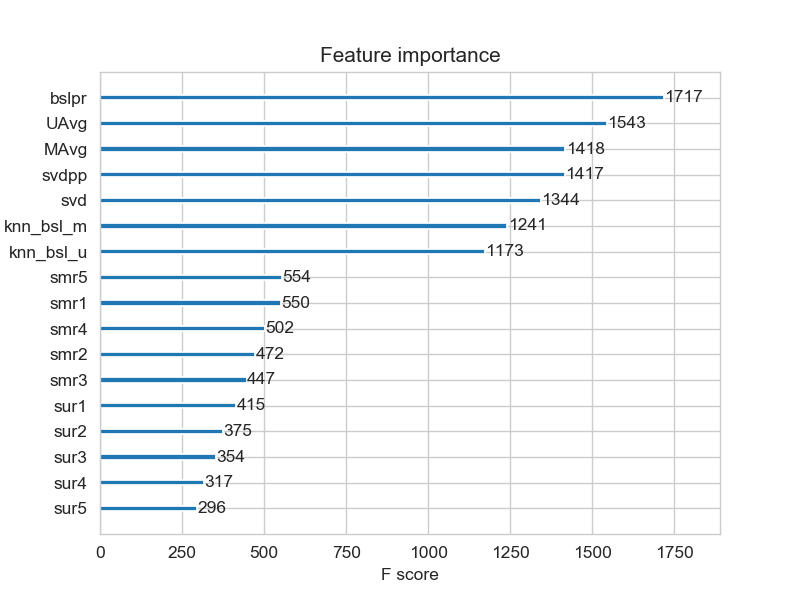

In [72]:
train_results, test_results = run_xgboost(xgb_all, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all)
plt.show()

In [88]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

param={"learning_rate" : [0.15, 0.20, 0.25,0.5,0.7] ,
 "n_estimators" : [ 100, 200, 400, 600,800,1000],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}
x5=xgb.XGBRegressor(n_jobs=10,random_state=15)
grid_3=GridSearchCV(x5,param_grid=param)
grid_resul=grid_3.fit(x_train,y_train)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [89]:
grid_resul.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=10, nthread=None, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [92]:
xgb_all_models=xgb.XGBRegressor(max_depth=5,learning_rate=0.15,gamma=0.1,n_estimators=100)

Training the model
Done. Time taken : 0:00:10.300379

Done 

Evaluating the model with the training data
Evaluating the Test Data

TEST DATA
------------------------------
RMSE :  1.08355653386
MAPE :  35.9648962933


<IPython.core.display.Javascript object>


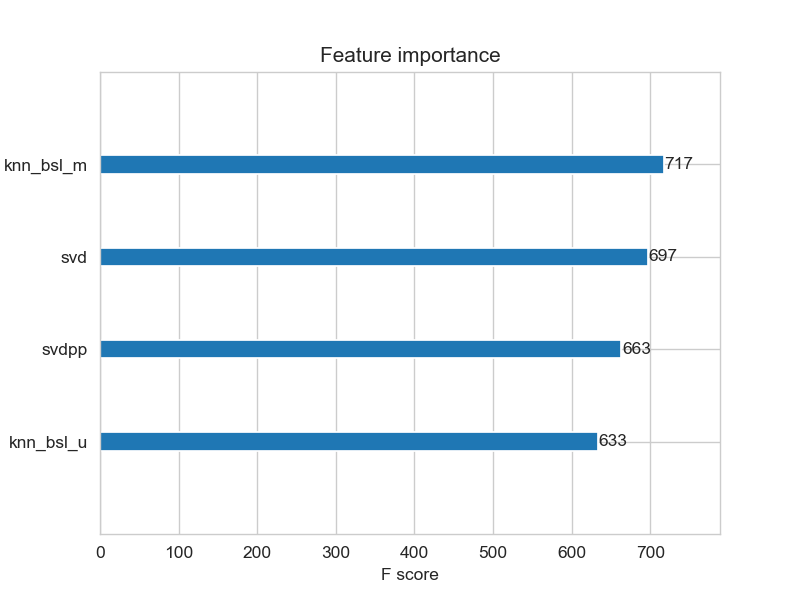

In [93]:
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [94]:
pd.DataFrame(models_evaluation_test).to_csv('result.csv')
res=pd.read_csv('result.csv',index_col=0)
res.loc['rmse'].sort_values()

knn_bsl_m         0.321238763308
knn_bsl_u         0.423883295481
svdpp             0.601902833235
svd                0.63813768452
first_algo        0.865230667502
xgb_knn_bsl       0.867476183026
xgb_bsl           0.936650861175
bsl_algo          0.950005080894
xgb_all_models     1.08355653386
Name: rmse, dtype: object

In [95]:
res.loc['mape'].sort_values()

knn_bsl_u         11.0575800204
svdpp             17.6386195064
svd               19.2920256196
first_algo        25.8808454378
xgb_knn_bsl       25.9164493309
xgb_bsl            27.504494587
bsl_algo          29.9624320151
xgb_all_models    35.9648962933
knn_bsl_m         8.07645693339
Name: mape, dtype: object

# Observation

In [ ]:

1. I have loaded all the required libraries for this assignment
2. We have read all the files and stored in a big file 
3. I have read the csv file,and sorted the data based on date
4. I have done the data preprocessing ,checking null value and duplicates 
5. I have spilted the data into Training and testing 
6. I have performed exploratory data analysis to check the basic statistics
7. I have created a sparse matrix stored in a file to use it further 
8. I have performed the basic data analysis on the rating 
9. I have computed Movie-movie similarity matrix 
10 I have sampled the data 25K Users and 3K movies for my Machine Learning Model.
11.I have performed some featurization techniques on train and test data for regression problem
12.I have applied xgboost as regressor with my hand made basic features and calculated the RMSE and MAPE
13.I have used Surprise library with BaselineOnly Model,KNNBaseline Model,SVD,SVD++ for fetaure engineering. then we merged the features 
   with our handmade features.
14. I have performed the hyperparameter tunning to find out best paramatere using GridSearchCV then i have built my model on
    using tunned parameters and calculated the RMSE and MAPE
15. I have compared the result of all the models    



# Comparison Between the Models

In [ ]:
                                                  RMSE            MAPE


    
Simple Model                                    0.8652            25.88                                                                         

BaseLinePredictor                               0.9500            29.96

BaslinePredictor + Simple                       0.8651            25.87     

KNNPredictor + Basline+ Simple                  0.86747           25.91

SVD + KNNPredictor + BaseLine + Simple          0.6381            19.29

SVD++ + SVD + KNNPredictor + Baseline + Simple  0.601             17.638 

In [19]:
%%javascript
// Converts integer to roman numeral
// https://github.com/kmahelona/ipython_notebook_goodies
// https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js
function romanize(num) {
    var lookup = {M:1000,CM:900,D:500,CD:400,C:100,XC:90,L:50,XL:40,X:10,IX:9,V:5,IV:4,I:1},
	roman = '',
	    i;
	for ( i in lookup ) {
	    while ( num >= lookup[i] ) {
		roman += i;
		num -= lookup[i];
	    }
	}
	return roman;
 }

// Builds a <ul> Table of Contents from all <headers> in DOM
function createTOC(){
    var toc = "";
    var level = 0;
    var levels = {}
    $('#toc').html('');

    $(":header").each(function(i){
	    if (this.id=='tocheading'){return;}
        
	    var titleText = this.innerHTML;
	    var openLevel = this.tagName[1];

	    if (levels[openLevel]){
		levels[openLevel] += 1;
	    } else{
		levels[openLevel] = 1;
	    }

	    if (openLevel > level) {
		toc += (new Array(openLevel - level + 1)).join('<ul class="toc">');
	    } else if (openLevel < level) {
		toc += (new Array(level - openLevel + 1)).join("</ul>");
		for (i=level;i>openLevel;i--){levels[i]=0;}
	    }

	    level = parseInt(openLevel);


	    if (this.id==''){this.id = this.innerHTML.replace(/ /g,"-")}
	    var anchor = this.id;
        
	    toc += '<li><a style="text-decoration:none", href="#' + encodeURIComponent(anchor) + '">' + titleText + '</a></li>';
        
	});

    
    if (level) {
	toc += (new Array(level + 1)).join("</ul>");
    }

 
    $('#toc').append(toc);

};

// Executes the createToc function
setTimeout(function(){createTOC();},100);

// Rebuild to TOC every minute
setInterval(function(){createTOC();},60000);

<IPython.core.display.Javascript object>